In [1]:
%load_ext autoreload
%autoreload 2

# Train a Baseline

In [2]:
import wandb
import torch
from tqdm.notebook import tqdm
from fastai.vision.all import *
from typing import List, Union, Tuple
from fastai.callback.wandb import WandbCallback

from segmentation.metrics import *
from segmentation.model import SegmentationModel
from segmentation.train_utils import benchmark_inference_time, save_model_to_artifacts

In [3]:
PROJECT="CamVid"
ENTITY="av-demo"
IMAGE_SHAPE = (720, 960)
SEED = 42
RUN_NAME = "final-fit-r34-2"
JOB_TYPE = "train"

ARTIFACT_ID = "camvid-dataset:latest"

BATCH_SIZE = 8
IMAGE_RESIZE_FACTOR = 2
VALIDATION_SPLIT_PCT = 0.2
HIDDEN_DIM = 256
BACKBONE = "resnet34"

LEARNING_RATE = 0.00065
TRAIN_EPOCHS = 15
WEIGHT_DECAY = 0.01

INFERENCE_BATCH_SIZE = 4
NUM_WARMUP_ITERS = 10
NUM_INFERENCE_BENCHMARK_ITERS = 100

MODE = None #"disabled"

In [4]:
set_seed(SEED)

In [5]:
run = wandb.init(
    project=PROJECT,
    name=RUN_NAME,
    entity=ENTITY,
    job_type=JOB_TYPE,
    mode=MODE,
    config={
        "artifact_id": ARTIFACT_ID,
        "image_shape": IMAGE_SHAPE,
        "batch_size": BATCH_SIZE,
        "image_resize_factor": IMAGE_RESIZE_FACTOR,
        "validation_split": VALIDATION_SPLIT_PCT,
        "hidden_dims": HIDDEN_DIM,
        "backbone": BACKBONE,
        "learning_rate": LEARNING_RATE,
        "train_epochs": TRAIN_EPOCHS,
        "inference_batch_size": INFERENCE_BATCH_SIZE,
        "num_warmup_iters": NUM_WARMUP_ITERS,
        "num_inference_banchmark_iters": NUM_INFERENCE_BENCHMARK_ITERS
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: capecape (use `wandb login --relogin` to force relogin)


## DataLoader for SegmentationDataLoader for Segmentation

In [6]:
def label_func(fn):
    return fn.parent.parent/"labels"/f"{fn.stem}_P{fn.suffix}"


def get_dataloaders(
    artifact_id: str, # the name of the artifact
    batch_size: int,  # the batch size for training, 2x for val
    resize_factor: int, # a integer resize factor for training
    validation_split_pct: float, # the validation percentage of data to be used in [0,1] 
    seed: int # the seed
):
    """Grab an artifact and creating a Pytorch DataLoader"""
    artifact = wandb.use_artifact(artifact_id, type='dataset')
    artifact_dir = Path(artifact.download())
    codes = np.loadtxt(artifact_dir/'codes.txt', dtype=str)
    fnames = get_image_files(artifact_dir/"images")
    class_labels = {k: v for k, v in enumerate(codes)}
    
    image_shape = load_image(fnames[0]).shape
    
    return SegmentationDataLoaders.from_label_func(
        artifact_dir,
        bs=batch_size,
        fnames=fnames,
        label_func=label_func,
        codes=codes,
        item_tfms=Resize((
            image_shape[0] // resize_factor,
            image_shape[1] // resize_factor
        )),
        valid_pct=validation_split_pct,
        seed=seed
    ), class_labels

wandb: Downloading large artifact camvid-dataset:latest, 1210.65MB. 1409 files... Done. 0:0:0


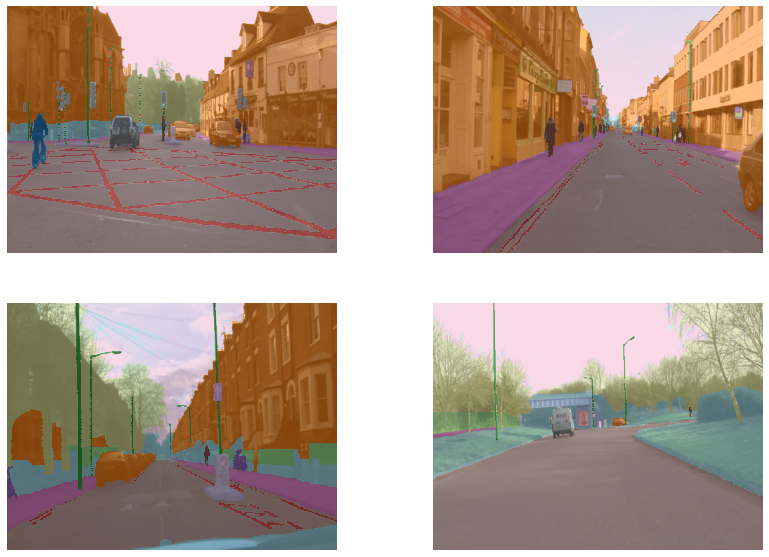

In [7]:
data_loader, class_labels = get_dataloaders(
    artifact_id=ARTIFACT_ID,
    batch_size=BATCH_SIZE,
    resize_factor=IMAGE_RESIZE_FACTOR,
    validation_split_pct=VALIDATION_SPLIT_PCT,
    seed=SEED
)

data_loader.show_batch(max_n=4, vmin=1, vmax=30, figsize=(14, 10))

## Training and Inference

Let's log a bucnh of useful data for model evaluation

In [8]:
def get_model_parameters(model):
    "Get total number of model params"
    with torch.no_grad():
        num_params = sum(p.numel() for p in model.parameters())
    return num_params

In [9]:
def get_predictions(learn, test_dl=None, max_n=None):
    "Return the samples = (x,y) and outputs (model predictions decoded), and predictions (raw preds)" 
    if test_dl is None:
        test_dl = learn.dls.valid
    inputs, predictions, targets, outputs = learn.get_preds(dl=test_dl, with_input=True, with_decoded=True)
    x, y, samples, outputs = learn.dls.valid.show_results(
        tuplify(inputs) + tuplify(targets), outputs, show=False, max_n=max_n
    )
    return samples, outputs, predictions

In [10]:
def get_learner(
    data_loader,
    backbone: str,
    hidden_dim: int,
    num_classes: int,
    checkpoint_file: Union[None, str, Path],
    loss_func,
    metrics: List,
    log_preds: bool = False
):
    model = SegmentationModel(backbone, hidden_dim, num_classes=num_classes)
    mixed_precision_callback = MixedPrecision()
    wandb_callback = WandbCallback(log_model=False, log_preds=log_preds)
    learner = Learner(
        data_loader,
        model,
        loss_func=loss_func,
        metrics=metrics,
        cbs=[mixed_precision_callback, wandb_callback],
    )
    if checkpoint_file is not None:
        load_model(checkpoint_file, learner.model, opt=None, with_opt=False)
        # learner.load(checkpoint_file)
    return learner

In [11]:
learn = get_learner(
    data_loader,
    backbone=BACKBONE,
    hidden_dim=HIDDEN_DIM,
    num_classes=len(class_labels),
    checkpoint_file=None,
    loss_func=FocalLossFlat(axis=1),
    metrics=[DiceMulti(), foreground_acc],
    log_preds=False,
)

## Log preds

In [12]:
def table_from_dl(learn, test_dl, class_labels):
    samples, outputs, predictions = get_predictions(learn, test_dl)
    table = create_dice_table(samples, outputs, predictions, class_labels)
    return table

In [13]:
learn.fit_one_cycle(TRAIN_EPOCHS, LEARNING_RATE)

epoch,train_loss,valid_loss,dice_multi,foreground_acc,time
0,1.812451,0.839243,0.158161,0.782207,00:23
1,0.815368,0.521723,0.231991,0.816838,00:18
2,0.451778,0.479713,0.344488,0.819707,00:18
3,0.302826,0.253490,0.442199,0.874062,00:18
4,0.216871,0.373930,0.444264,0.811964,00:18
5,0.171425,0.194620,0.514911,0.893502,00:18
6,0.134440,0.157838,0.566000,0.907929,00:18
7,0.115586,0.149766,0.567981,0.912354,00:18
8,0.098920,0.141745,0.577655,0.915004,00:18
9,0.086934,0.138545,0.609844,0.915260,00:18


In [15]:
wandb.alert("Training Succesufuly!!!", f"After {TRAIN_EPOCHS}: run: {wandb.run.name} epochs succesuful")

In [16]:
pred_table = table_from_dl(learn, learn.dls.valid, class_labels)

In [ ]:
wandb.log({f"Predictions_Table": pred_table})

In [ ]:
wandb.alert("Computing Predictions",  f"run: {wandb.run.name} logged 140 preds to Prediction_Table succesuful")

## Save models

In [ ]:
save_model_to_artifacts(
    learn.model, 
    f"Unet_{BACKBONE}", 
    image_shape=IMAGE_SHAPE,
    artifact_name=f"{run.name}-saved-model",
    metadata={
        "backbone": BACKBONE,
        "hidden_dims": HIDDEN_DIM,
        "input_size": IMAGE_SHAPE,
        "class_labels": class_labels
    }
)

Saving model checkpoint
Saving model using scripting...
Done!!!
Saving model using tracing...
Done!!!


In [ ]:
model_file = f"Unet_{BACKBONE}_traced.pt"

In [ ]:
def benchmark_inference_time(
    model_file,
    image_shape: tuple[int, int],
    batch_size: int,
    num_warmup_iters: int,
    num_iter: int,
    seed: int,
):
    model = torch.jit.load(model_file).cuda()
    
    dummy_input = torch.randn(
        batch_size, 3, image_shape[0] // 2, image_shape[0] // 2, dtype=torch.float
    ).to("cuda")

    starter, ender = (
        torch.cuda.Event(enable_timing=True),
        torch.cuda.Event(enable_timing=True),
    )
    timings = np.zeros((num_iter, 1))

    print("Warming up GPU...")
    for _ in progress_bar(range(num_warmup_iters)):
        _ = model(dummy_input)

    print(
        f"Computing inference time over {num_iter} iterations with batches of {batch_size} images..."
    )

    with torch.inference_mode():
        for step in progress_bar(range(num_iter)):
            starter.record()
            _ = model(dummy_input)
            ender.record()
            torch.cuda.synchronize()
            timings[step] = starter.elapsed_time(ender)

    return np.sum(timings) / (num_iter * batch_size)

In [ ]:
torch.cuda.empty_cache()
inference_time = benchmark_inference_time(model_file,
                    batch_size=INFERENCE_BATCH_SIZE,
                    image_shape=IMAGE_SHAPE,
                    num_warmup_iters=NUM_WARMUP_ITERS,
                    num_iter=NUM_INFERENCE_BENCHMARK_ITERS,
                    seed=SEED
                    )

wandb.log({"inference_time":inference_time})

In [ ]:
wandb.aler("Killing VM", "Run {wandb.run.name} ended, killing VM")

In [ ]:
wandb.finish()